# Numerical Scientific Computing Miniproject 1

### Setting up packages and parameters

In [132]:
import timeit
from numba import jit
import dask.array as desk
import multiprocessing as mp
import numpy as numerinopyndarino
import matplotlib.pyplot as ploterino

In [133]:
#Parameters
pim = 500
pre = 500
I = 100
T = 2

### Declare different datatypes for testing

The three types are

csingle     | float complex       | Complex number, represented by two single-precision floats (real and imaginary components).

cdouble     | double complex      | Complex number, represented by two double-precision floats (real and imaginary components).

clongdouble | long double complex | Complex number, represented by two extended-precision floats (real and imaginary components).

The main difference between them is that in float we can store values up to 4 bytes (6 places after decimal point). Double up to 8 bytes, and long double even more than float and double.

In [54]:

dtypes = [numerinopyndarino.csingle, numerinopyndarino.cdouble, numerinopyndarino.clongdouble]
print(dtypes)

[<class 'numpy.complex64'>, <class 'numpy.complex128'>, <class 'numpy.complex256'>]


### Generate the complex matrix C

A function is declared that generates the complex matrix C with a given dataype.

In [111]:
def generate_complex_c(pim, pre, dtype):
    C = numerinopyndarino.zeros((pim, pre), dtype=dtype) #Generate the C matrix with the given dimesion pim x pre
    re = numerinopyndarino.tile(numerinopyndarino.linspace(-2, 1, pim, dtype=dtype),(pim,1)) #Generate real numbers from -2 to 1, with pim intervals (Stored in a pim x pim matrix)
    im = numerinopyndarino.tile(numerinopyndarino.linspace(1.5, -1.5, pre, dtype=dtype), (pre,1)).T #Generate imaginary numbers from -1.5 to 1.5 with pre intervals (Stored in a pre x pre matrix)
    C = re + im*1j
    return C

### Testing the speed of different datatypes

This section tests the datatypes on the previously implemented methods: Naive and Vectorized.

First, we declare a function for each method:

In [63]:
#Naive
def naive(C, I, T):
    M = numerinopyndarino.zeros(C.shape) #Declare our output matrix M

    for row in range(C.shape[0]):  #Loop through each complex number c in our C matrix
        for col in range(C.shape[1]):

            c = C[row, col]
            z = 0 + 0j

            for i in range(I-1): #Calculate I iterations of z with formula: z_(i+1) = z_i ^2 + c
                
                z = (z**2) + c

                if (numerinopyndarino.abs(z) > T): #Calculate l(c) as the index where |z_i| > T
                    lc = i
                    break #Break out of the loop if already diverged!
                else:
                    lc = I

            M[row, col] = lc/I #Store lc to the output matrix M. We divide by I to map from 0-1.
    return M

In [64]:
#Vectorized
def vectorized(C, I, T, dtype):
    M = numerinopyndarino.zeros(C.shape, dtype=int) #Declare our output matrix M

    Z = numerinopyndarino.zeros(C.shape, dtype=dtype) #Declare Z as a matrix, where we calculate z = z²+c for each point in C

    for i in range(I-1):
        Z = Z*Z + C

        M[numerinopyndarino.abs(Z) > T] = i

    M[numerinopyndarino.abs(Z) <= T] = I

    return M

Timeit is used to measure the time for each datatype

In [167]:
#The results are stored in these lists
naive_results = []
vectorized_results = []
print("---------")
#NAIVE
for dtype in dtypes: #Loop all the datatypes
    C = generate_complex_c(pim, pre, dtype) #Generate the complex matrix with the given datatype
    #NAIVE
    print("Naive Implementation with the datatype: ", dtype)
    naive_result = timeit.Timer(lambda: naive(C, I, T)).timeit(5) #Calculate the time for the naive implementation
    naive_results.append(naive_result)
    print("Time: ", naive_result)

    print("---------")

#VECTORIZED
for dtype in dtypes: #Loop all the datatypes
    C = generate_complex_c(pim, pre, dtype) #Generate the complex matrix with the given datatype
    #VECTORIZED
    print("Vectorized Implementation with the datatype: ", dtype)
    vectorized_result = timeit.Timer(lambda: vectorized(C, I, T, dtype)).timeit(5) #Calculate the time for the vectorized implementation
    vectorized_results.append(vectorized_result)
    print("Time: ", vectorized_result)   

    print("----------")

---------
Naive Implementation with the datatype:  <class 'numpy.complex64'>
Time:  64.68435700703412
---------
Naive Implementation with the datatype:  <class 'numpy.complex128'>
Time:  60.704475726000965
---------
Naive Implementation with the datatype:  <class 'numpy.complex256'>
Time:  61.20647003711201
---------
Vectorized Implementation with the datatype:  <class 'numpy.complex64'>


/tmp/ipykernel_1309251/4180854526.py:8: RuntimeWarning: overflow encountered in multiply
  Z = Z*Z + C
/tmp/ipykernel_1309251/4180854526.py:8: RuntimeWarning: invalid value encountered in multiply
  Z = Z*Z + C
/tmp/ipykernel_1309251/4180854526.py:10: RuntimeWarning: overflow encountered in absolute
  M[numerinopyndarino.abs(Z) > T] = i


Time:  2.998754322063178
----------
Vectorized Implementation with the datatype:  <class 'numpy.complex128'>
Time:  4.416382751893252
----------
Vectorized Implementation with the datatype:  <class 'numpy.complex256'>
Time:  18.129121734993532
----------


### Plot the processing times

The times are plotted using matplotlib

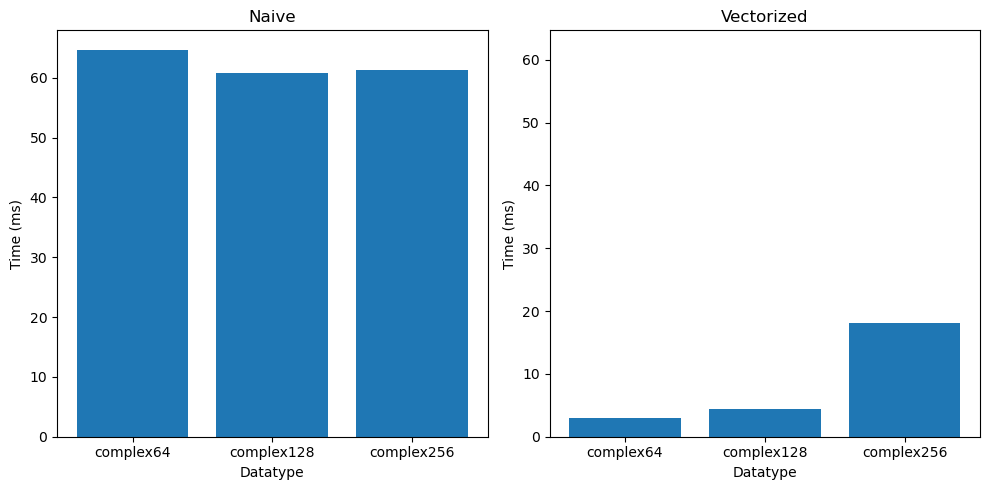

In [168]:
fig = ploterino.figure(figsize=(10, 5))
ax = fig.subplots(1, 2)

ax[0].bar(['complex64', 'complex128', 'complex256'], naive_results)
ax[0].set_title('Naive')
ax[0].set_ylabel('Time (ms)')
ax[0].set_xlabel('Datatype')

ax[1].bar(['complex64', 'complex128', 'complex256'], vectorized_results)
ax[1].set_title('Vectorized')
ax[1].set_ylabel('Time (ms)')
ax[1].set_xlabel('Datatype')
ax[1].set_ylim(0, max(naive_results))

fig.tight_layout()

ploterino.show()


The naive method improves slightly when the datatype has more bytes to store the precision.

The vectorized method is the complete opposite, and gets worse with an increase in the amount of bytes.

#### Time for some dask!

We define a function to use the naive implementation with dask.

In [212]:
#Generate the C matrix and convert it to a dask array
C = generate_complex_c(pim, pre, dtypes[0])

#List of chunk sizes to test
chunks = [(10, 10), (50, 50), (100, 100), (250, 250), (500, 500)]

#Define a function for the dask method so we can time it
def func(x):
    out = desk.map_blocks(lambda x: naive(x, I, T), x)
    return out.compute()

dask_results = []
for c in chunks:
    print("Computing dask with chunk size: ", c)
    #Create dask array from numpy array using a given chunk size.
    C_dask = desk.from_array(C, chunks=c)

    #Run the vectorized function using dask
    dask_result = timeit.Timer(lambda: func(C_dask)).timeit(5)
    
    #Append results
    dask_results.append(dask_result)

    print("Time: ", dask_result),
    print('---------')

Computing dask with chunk size:  (10, 10)
Time:  1087.0107033881359
---------
Computing dask with chunk size:  (50, 50)
Time:  78.68405319005251
---------
Computing dask with chunk size:  (100, 100)
Time:  77.0703486839775
---------
Computing dask with chunk size:  (250, 250)
Time:  56.84476254018955
---------
Computing dask with chunk size:  (500, 500)
Time:  52.90506706782617
---------


### Plot the processing times

The times are plotted using matplotlib

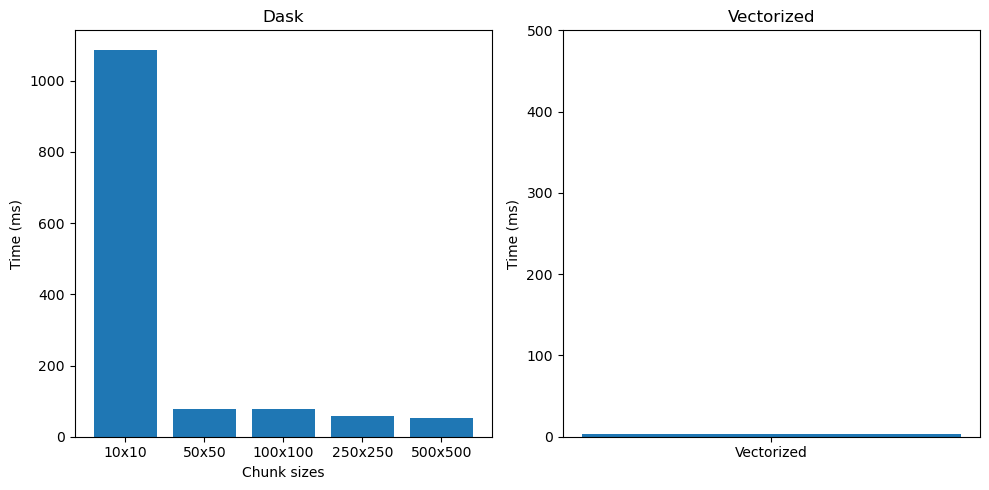

Best Dask:  52.90506706782617
Vectorized:  2.998754322063178


In [216]:
fig = ploterino.figure(figsize=(10, 5))
ax = fig.subplots(1, 2)

ax[0].bar(['10x10', '50x50', '100x100', '250x250', '500x500'], dask_results)
ax[0].set_title('Dask')
ax[0].set_ylabel('Time (ms)')
ax[0].set_xlabel('Chunk sizes')

ax[1].bar(['Vectorized'], min(vectorized_results))
ax[1].set_title('Vectorized')
ax[1].set_ylabel('Time (ms)')
ax[1].set_ylim(0, 500)

fig.tight_layout()

ploterino.show()

print("Best Dask: ", min(dask_results))
print("Vectorized: ", min(vectorized_results))


We can see that for the dask method it is better to have bigger chunk sizes.
The vectorized method is much better than the best dask method - maybe chatGPT could have done it better than me :(